### Imports

In [16]:
# Imports and set up
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt
from torcheeg.io.eeg_signal import EEGSignalIO
from torcheeg.models import DGCNN
from sklearn.model_selection import train_test_split
from einops import rearrange

from torcheeg import transforms
from torcheeg.models.gnn.dgcnn import Chebynet
from torcheeg.models.gnn.dgcnn import GraphConvolution


## CKA stuff
import os
from cka import CKACalculator


## Path to dir with data (remember the last '/')
path = "../../data/"

## Establish connection to datafile
IO = EEGSignalIO(io_path=str(path), io_mode='lmdb')
## Read metadata dataframeimports
metadata = pd.read_csv(path + 'sample_metadata.tsv', sep='\t')

### Load data

In [2]:
# Verifying connextion to data
idxs = np.arange(len(metadata))

X = torch.FloatTensor(np.array([IO.read_eeg(str(i)) for i in idxs]))
print(f"nsamples: {X.shape[0]}  -  nchannels: {X.shape[1]}  -  t: {X.shape[2]}")

y = torch.tensor(metadata["value"].values, dtype=torch.long)

nsamples: 5184  -  nchannels: 22  -  t: 800


In [3]:
t = transforms.BandDifferentialEntropy(band_dict={
                          "delta": [1, 4],
                          "theta": [4, 8],
                          "alpha": [8, 14],
                          "beta": [14, 31],
                          "gamma": [31, 49]
                      })

X_bde = []
for i in range(X.shape[0]):
    
    bde_tmp = t(eeg=X[i])
    X_bde.append(bde_tmp)
    
X_bde = [x["eeg"] for x in X_bde]

with open("preprocessed_data.npy", "wb") as f:
    np.save(f, X_bde)

In [4]:
with open("preprocessed_data.npy", "rb") as f:
    X_bde = np.load(f)

In [5]:
X_bde = torch.FloatTensor(X_bde)

### Split data into train, validation and test sets

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_bde, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(f"shape of X train: {X_train.shape}")
print(f"shape of X val: {X_val.shape}")
print(f"shape of X test: {X_test.shape}")

print(f"shape of y train: {y_train.shape}")
print(f"shape of y val: {y_val.shape}")
print(f"shape of y test: {y_test.shape}")

shape of X train: torch.Size([3110, 22, 5])
shape of X val: torch.Size([1037, 22, 5])
shape of X test: torch.Size([1037, 22, 5])
shape of y train: torch.Size([3110])
shape of y val: torch.Size([1037])
shape of y test: torch.Size([1037])


In [9]:
#set up of matrixies 
#number of samples, channels, and timesteps
nsamples_train, nchannels_train, bands = X_train.shape
nsamples_val, nchannels_val, bands = X_val.shape

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

adj_matrix_train = torch.eye(nchannels_train)
adj_matrix_val = torch.eye(nchannels_val)

In [10]:
print(adj_matrix_train.shape)
print(type(adj_matrix_train))
print(nsamples_train)

print(adj_matrix_val.shape)
print(type(adj_matrix_val))
print(nsamples_val)

torch.Size([22, 22])
<class 'torch.Tensor'>
3110
torch.Size([22, 22])
<class 'torch.Tensor'>
1037


### Model training definition

In [11]:
class TrainNN():
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def train_model(self, model, train_loader, val_loader, learning_rate, w_decay=1e-4,epochs=100, prints=True,modrun=0):
        model = model.to(self.device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=w_decay)

        highest_train_accuracy = 0.0
        
        losses_train = []; losses_val = []

        for epoch in range(epochs):
            model.train()
            running_loss = 0.0; running_loss_val = 0.0
            correct = 0; correct_val = 0
            total = 0; total_val = 0
            
            for inputs, labels in train_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                optimizer.zero_grad()
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_accuracy = correct/total
            losses_train.append(epoch_loss)
            
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss_val += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                
            epoch_loss_val = running_loss_val / len(val_loader.dataset)
            epoch_accuracy_val = correct_val/total_val
            losses_val.append(epoch_loss_val)
                
            if epoch_accuracy > highest_train_accuracy:
                highest_train_accuracy = epoch_accuracy

            if prints:
                print(f"Epoch {epoch+1}/{epochs}, Train loss: {epoch_loss:.4f}, Train acc: {(epoch_accuracy*100):.2f}%" +
                     f"| Val loss: {epoch_loss_val:.4f}, Val acc: {(epoch_accuracy_val*100):.2f}%")

        print(f"Highest Train Accuracy {(highest_train_accuracy*100):.2f}")
        torch.save(model.state_dict(), f'eeg_nnmod{modrun}.pth')

        
        losses = [losses_train, losses_val]

        return model, losses

### Training & model hyperparameters

In [12]:
# Model parameters
n_chans = 22
n_outputs = y.max().item() + 1
n_times = 800
dropout = 0.6
n_kernels = 40
kernel_size = 25
pool_size = 100

# Training parameters
lr = 1e-3
epochs = 20

#Models 
modruns = 4

In [13]:
dgcnn_model = DGCNN(in_channels=5, num_electrodes=22, hid_channels=32, num_layers=2, num_classes=n_outputs)

trainer = TrainNN()

dgcnn = trainer.train_model(dgcnn_model, train_loader, val_loader, learning_rate=1e-4, w_decay=0,epochs=20, prints=True,modrun=1)

Epoch 1/20, Train loss: 1.5041, Train acc: 26.30%| Val loss: 1.4264, Val acc: 29.70%
Epoch 2/20, Train loss: 1.3952, Train acc: 32.35%| Val loss: 1.3774, Val acc: 32.69%
Epoch 3/20, Train loss: 1.3611, Train acc: 34.21%| Val loss: 1.3635, Val acc: 33.56%
Epoch 4/20, Train loss: 1.3384, Train acc: 35.72%| Val loss: 1.3487, Val acc: 35.10%
Epoch 5/20, Train loss: 1.3256, Train acc: 36.53%| Val loss: 1.3425, Val acc: 35.10%
Epoch 6/20, Train loss: 1.3102, Train acc: 39.23%| Val loss: 1.3290, Val acc: 36.93%
Epoch 7/20, Train loss: 1.3019, Train acc: 38.65%| Val loss: 1.3276, Val acc: 35.87%
Epoch 8/20, Train loss: 1.2920, Train acc: 39.55%| Val loss: 1.3203, Val acc: 36.35%
Epoch 9/20, Train loss: 1.2822, Train acc: 40.29%| Val loss: 1.3229, Val acc: 35.87%
Epoch 10/20, Train loss: 1.2803, Train acc: 41.06%| Val loss: 1.3194, Val acc: 35.29%
Epoch 11/20, Train loss: 1.2682, Train acc: 42.28%| Val loss: 1.3112, Val acc: 36.64%
Epoch 12/20, Train loss: 1.2608, Train acc: 41.67%| Val loss: 1

### Training

In [14]:
mods=[]
def train_models(models=1,new =False):
    for i in range(models):
        tmp_mod=DGCNN(in_channels=5, num_electrodes=22, hid_channels=32, num_layers=2, num_classes=n_outputs)
        pth=f"eeg_nnmod{i}.pth"
        if new or not os.path.exists(pth):    
            trainer = TrainNN()
            mods.append(trainer.train_model(tmp_mod, train_loader, val_loader, learning_rate=lr, w_decay=0,epochs=epochs, prints=False, modrun=i))
        else: 
            tmp_mod.load_state_dict(torch.load(f"eeg_nnmod{i}.pth"))
            tmp_mod.eval()
            mods.append([tmp_mod,[]])

train_models(modruns,new=True)


Highest Train Accuracy 59.00
Highest Train Accuracy 61.70
Highest Train Accuracy 60.03
Highest Train Accuracy 62.77


Processing CKA: 100%|█████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 173.43it/s]


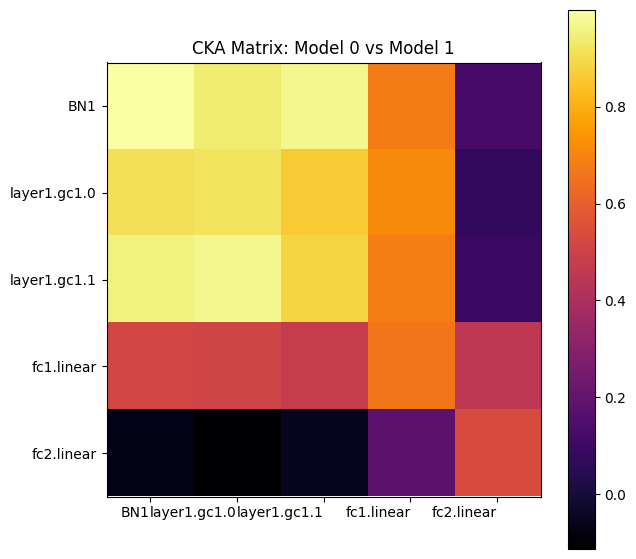

Processing CKA: 100%|█████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 139.78it/s]


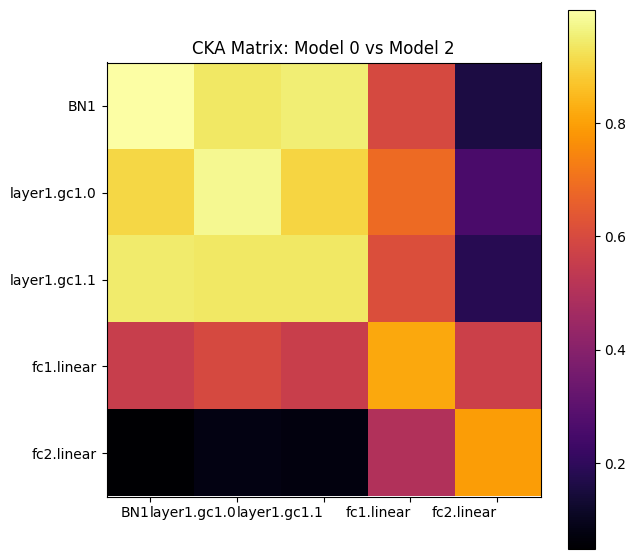

Processing CKA: 100%|██████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 90.29it/s]


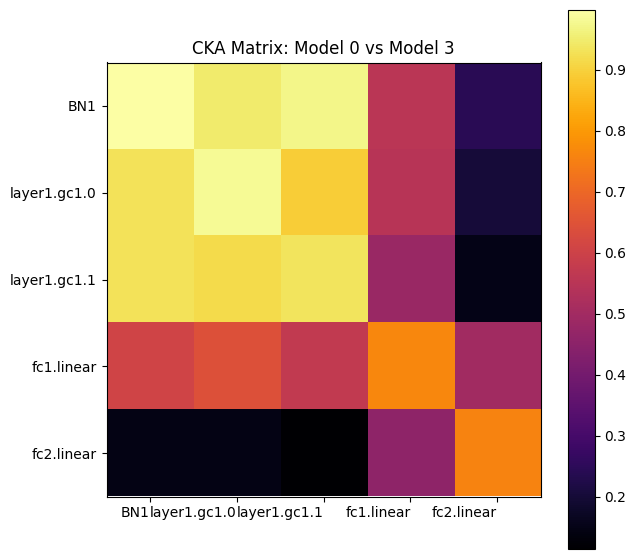

In [17]:
for i in range(modruns - 1):
    calculator = CKACalculator(model1=mods[0][0], model2=mods[i + 1][0], dataloader=train_loader,
                               layers_to_hook=(nn.Conv2d, nn.Linear, nn.AdaptiveAvgPool2d, GraphConvolution, nn.BatchNorm1d))
    cka_output = calculator.calculate_cka_matrix()

    # Plot the matrix
    plt.figure(figsize=(7, 7))
    plt.imshow(cka_output.cpu().numpy(), cmap='inferno')
    plt.xticks(ticks=np.arange(len(calculator.module_names_X)), labels=calculator.module_names_X, ha="right")
    plt.yticks(ticks=np.arange(len(calculator.module_names_Y)), labels=calculator.module_names_Y)
    plt.colorbar()
    plt.title(f'CKA Matrix: Model 0 vs Model {i+1}')
    plt.show()  


In [22]:
print(len(mods))

4


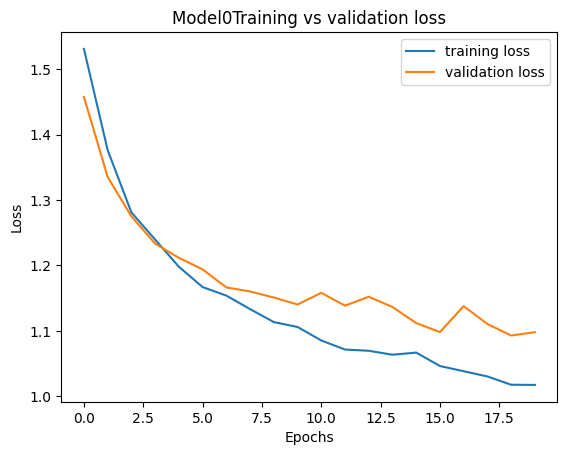

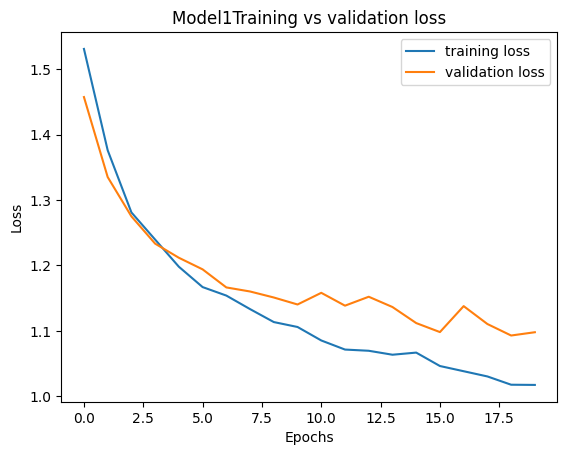

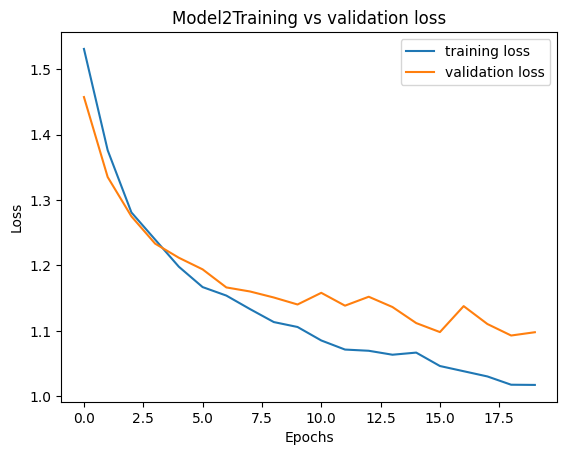

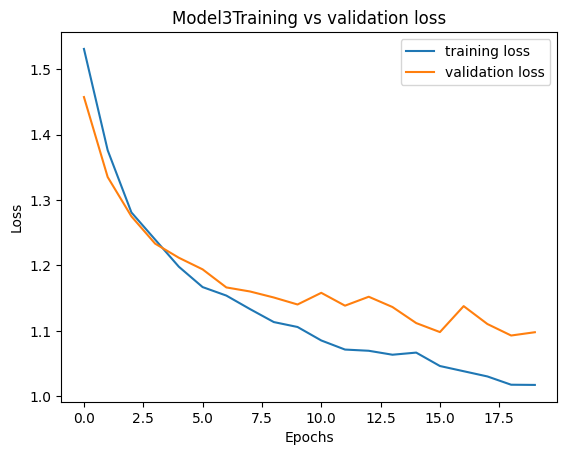

In [ ]:
for i  in range (len(mods)):
    plt.plot(mods[0][1][0])
    plt.plot(mods[0][1][1])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["training loss","validation loss"])
    plt.title(f"Model{i} Training vs validation loss")
    plt.show()  